# Greedy Algorithm

## Setup

In [1]:
from graphs_2d import *

## Graph Definition

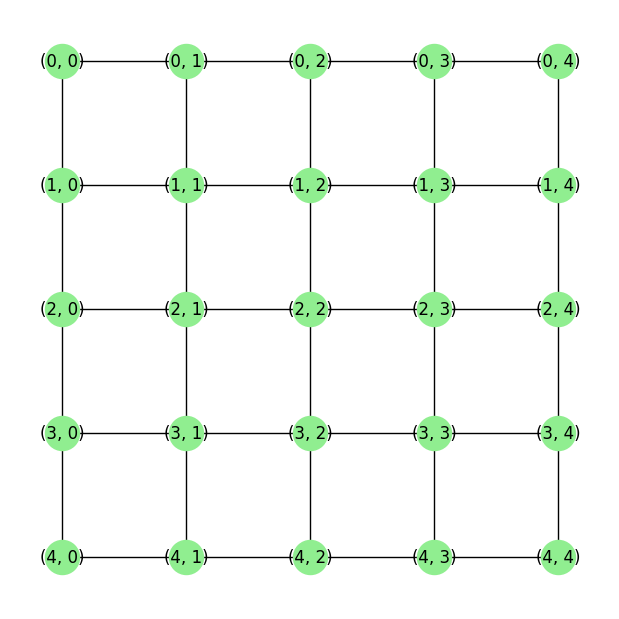

networkx.classes.graph.Graph

In [2]:
# Generate a single graph
rows, cols = 5, 5
grid_graph = generate_2D_grid_graph(rows, cols)
adjacency_matrix = nx.adjacency_matrix(grid_graph).todense()

plot_graph(grid_graph, 'grid')

type(grid_graph)

## Starting Node Selection

### Weighted Select

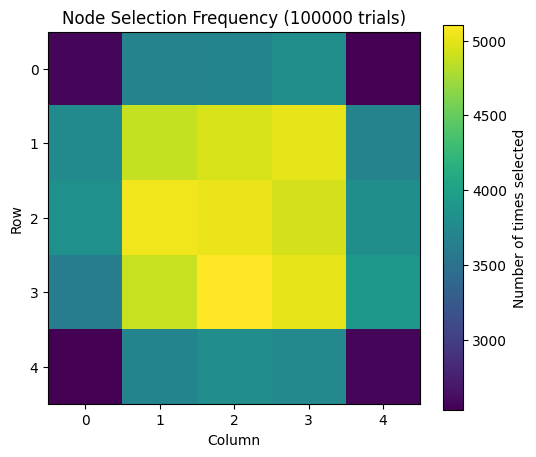

In [3]:
# Run the selection 10000 times
counts = np.zeros(len(grid_graph.nodes()))
for _ in range(100000):
    node = select_starting_node_8way_probablistic(grid_graph)
    node_index = list(grid_graph.nodes()).index(node)
    counts[node_index] += 1

# Reshape counts to match the grid for visualization
counts_matrix = counts.reshape((rows, cols))

plt.figure(figsize=(6, 5))
plt.imshow(counts_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Number of times selected')
plt.title('Node Selection Frequency (100000 trials)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

### Equal Select From Highest Neighbors

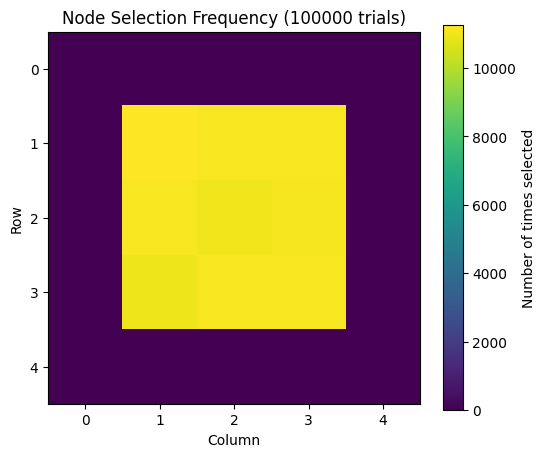

In [4]:
# Run the selection 10000 times
counts = np.zeros(len(grid_graph.nodes()))
for _ in range(100000):
    node = select_starting_node_max_neighbors(grid_graph)
    node_index = list(grid_graph.nodes()).index(node)
    counts[node_index] += 1

# Reshape counts to match the grid for visualization
counts_matrix = counts.reshape((rows, cols))

plt.figure(figsize=(6, 5))
plt.imshow(counts_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Number of times selected')
plt.title('Node Selection Frequency (100000 trials)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

## Finding MCDS in 2D Graphs

### Greedy Algorithm Function

#### Normal Greedy Algorithm Function

In [5]:
def greedy_connected_dominating_set(G, select_start):
    dominating_set = set([select_start(G)])
    dominated = set([select_start(G)])
    dominated.update(adjacent_8(G, select_start(G)))

    # While not all nodes are dominated
    while len(dominated) < G.number_of_nodes():
        # Candidates: nodes adjacent (4-way) to the dominating set, not already in it
        candidates = set()
        for node in dominating_set:
            for neighbor in adjacent_4(G, node):
                if neighbor not in dominating_set:
                    candidates.add(neighbor)
        # For each candidate, count how many new nodes it would dominate
        best_candidate = None
        max_new = -1
        for candidate in candidates:
            new_dominated = set(adjacent_8(G, candidate) + [candidate]) - dominated
            if len(new_dominated) > max_new:
                max_new = len(new_dominated)
                best_candidate = candidate
        # Add the best candidate to the dominating set
        if best_candidate is not None:
            dominating_set.add(best_candidate)
            dominated.update(adjacent_8(G, best_candidate))
            dominated.add(best_candidate)
        else:
            # If no candidate found (should not happen in a connected grid), break
            break
    return dominating_set

#### Probabilistic Greedy Algorithm Function

In [6]:
def probabilistic_greedy_connected_dominating_set(G, select_start):
    dominating_set = set([select_start(G)])
    dominated = set([select_start(G)])
    dominated.update(adjacent_8(G, select_start(G)))

    while len(dominated) < G.number_of_nodes():
        # Candidates: nodes adjacent (4-way) to the dominating set, not already in it
        candidates = set()
        for node in dominating_set:
            for neighbor in adjacent_4(G, node):
                if neighbor not in dominating_set:
                    candidates.add(neighbor)
        if not candidates:
            break  # Should not happen in a connected grid

        # For each candidate, count how many new nodes it would dominate
        candidate_list = list(candidates)
        new_dominated_counts = []
        for candidate in candidate_list:
            new_dominated = set(adjacent_8(G, candidate) + [candidate]) - dominated
            new_dominated_counts.append(len(new_dominated))

        # If all candidates would dominate 0 new nodes, break
        if sum(new_dominated_counts) == 0:
            break

        # Select a candidate with probability proportional to new_dominated_counts
        selected_candidate = random.choices(candidate_list, weights=new_dominated_counts, k=1)[0]

        dominating_set.add(selected_candidate)
        dominated.update(adjacent_8(G, selected_candidate))
        dominated.add(selected_candidate)

    return dominating_set

### Visualize Greedy Solution

{(1, 2), (2, 1), (3, 1), (1, 1), (2, 0), (2, 3), (1, 3)}


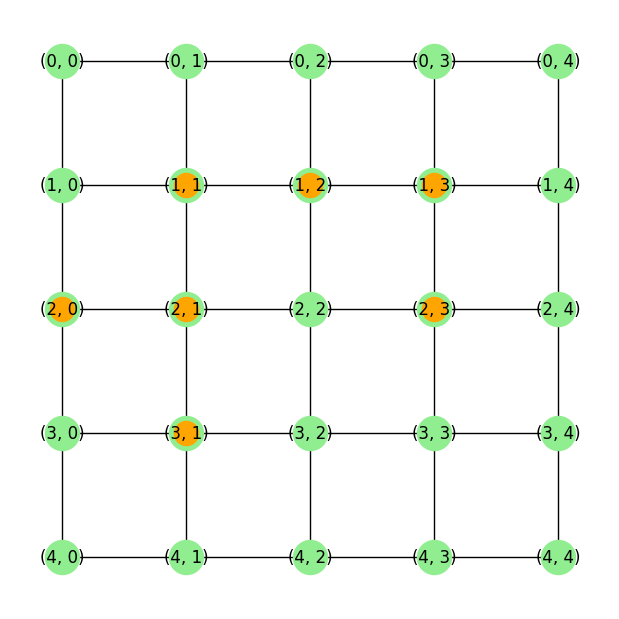

In [7]:
overlay_subset(grid_graph, greedy_connected_dominating_set(grid_graph, select_starting_node_8way_probablistic), 'grid')

{(1, 2), (2, 1), (3, 1), (1, 1), (3, 0), (2, 3), (1, 3)}


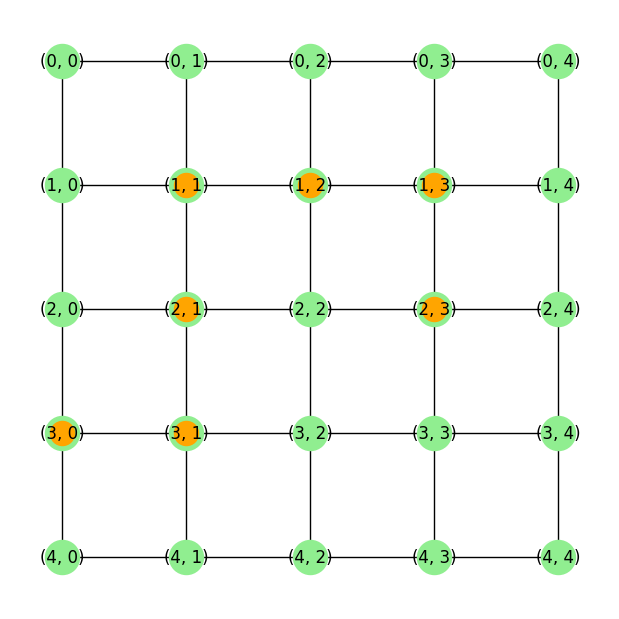

In [8]:
overlay_subset(grid_graph, greedy_connected_dominating_set(grid_graph, select_starting_node_max_neighbors), 'grid')

#### Visualize Probabilistic Greedy Function

{(1, 2), (3, 1), (1, 1), (2, 3), (3, 3), (3, 2), (1, 3)}


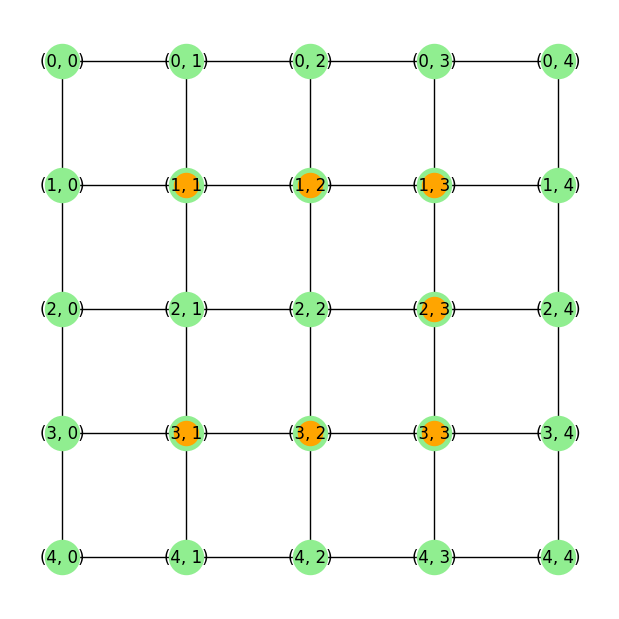

In [9]:
overlay_subset(grid_graph, probabilistic_greedy_connected_dominating_set(grid_graph, select_starting_node_8way_probablistic), 'grid')

### Greedy with Filter Check

#### Filter Method

In [10]:
def mcds_filtering(G, sub_G=None):
    """Finds a connected dominating set by filtering out nodes, starting from those with least degree."""
    if sub_G is None:
        sub_G = G
    nodes = sub_G.nodes()
    
    changed = True
    while changed:
        changed = False
        # Sort nodes by degree (ascending: least degree first)
        sorted_nodes = sorted(nodes, key=lambda n: sub_G.degree[n])
        for node in sorted_nodes:
            test_set = nodes - {node}
            if len(test_set) == 0:
                continue
            if is_connected_dominating_set(G, test_set):
                nodes = test_set
                changed = True
                break  # Restart after any removal
    return nodes

#### Greedy with Filter

In [11]:
def greedy_filtered(G, start_node):
    """Greedy algorithm for connected dominating set with filtering."""
    sub_G = G.subgraph(greedy_connected_dominating_set(G, start_node))
    return mcds_filtering(G, sub_G)

### Comparisons

#### Comparison of Starting Node Selection Methods

Running trials: 100%|██████████| 100/100 [00:05<00:00, 18.37it/s]
C:\Users\there\AppData\Local\Temp\ipykernel_26492\417675087.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


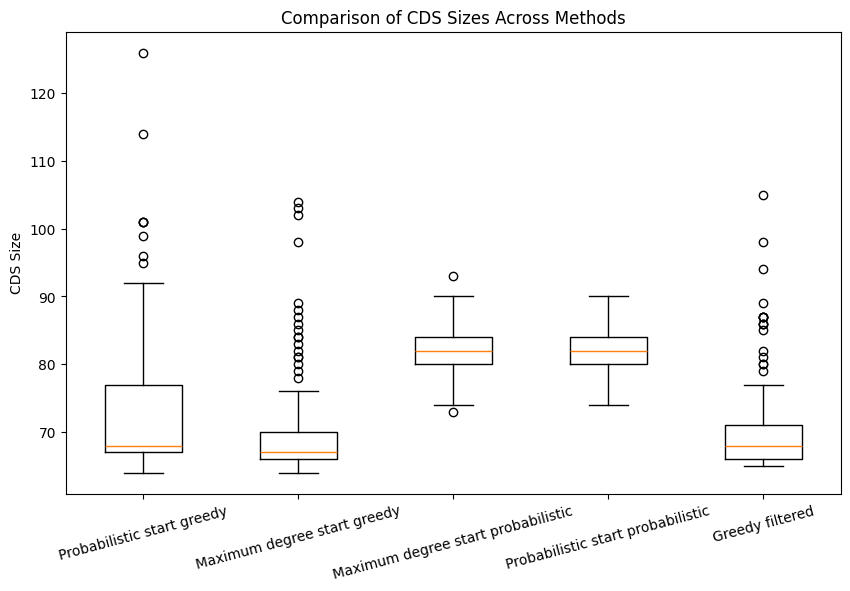

In [12]:
num_trials = 100
grid_graph = generate_2D_grid_graph(20, 10)

s1, _ = measure_runtime(
    greedy_connected_dominating_set,
    grid_graph, 
    select_starting_node_8way_probablistic, 
    trials=num_trials
)

s2, _ = measure_runtime(
    greedy_connected_dominating_set, 
    grid_graph, 
    select_starting_node_max_neighbors, 
    trials=num_trials
)

s3, _ = measure_runtime(
    probabilistic_greedy_connected_dominating_set, 
    grid_graph, 
    select_starting_node_max_neighbors, 
    trials=num_trials
)

s4, _ = measure_runtime(
    probabilistic_greedy_connected_dominating_set, 
    grid_graph, 
    select_starting_node_8way_probablistic, 
    trials=num_trials
)

s5, _ = measure_runtime(
    greedy_filtered, 
    grid_graph, 
    select_starting_node_max_neighbors, 
    trials=num_trials
)

# Convert sets/NodeViews to their lengths for boxplot
data = [
    [len(x) for x in s1],
    [len(x) for x in s2],
    [len(x) for x in s3],
    [len(x) for x in s4],
    [len(x) for x in s5]
]

labels = [
    "Probabilistic start greedy",
    "Maximum degree start greedy",
    "Maximum degree start probabilistic",
    "Probabilistic start probabilistic",
    "Greedy filtered"
]

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels)
plt.ylabel("CDS Size")
plt.title("Comparison of CDS Sizes Across Methods")
plt.xticks(rotation=15)
plt.show()

{(5, 4), (4, 6), (5, 1), (2, 2), (2, 5), (6, 2), (6, 5), (6, 8), (4, 5), (4, 8), (5, 3), (8, 2), (8, 5), (8, 8), (2, 4), (1, 2), (2, 1), (1, 5), (4, 7), (3, 5), (5, 2), (5, 5), (5, 8), (8, 1), (1, 1), (2, 3), (7, 2), (7, 5), (7, 8)}


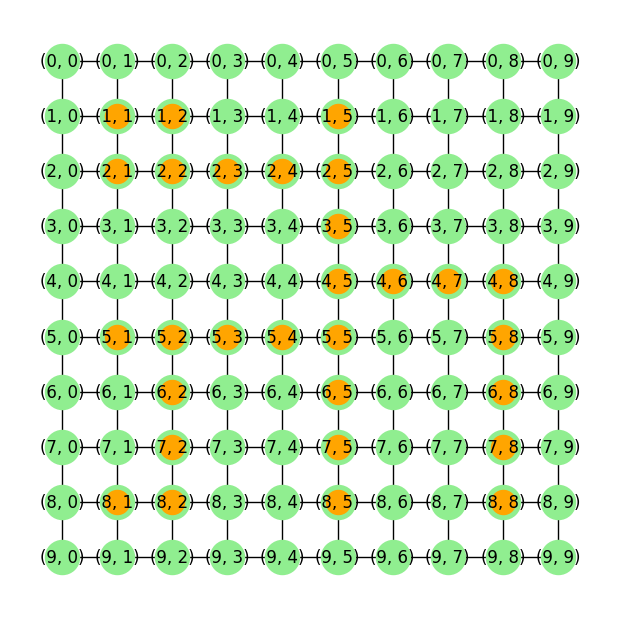

29


In [13]:
grid_graph = generate_2D_grid_graph(10, 10)
num_trials = 1000
min_set, min_len = get_minimum_from_trials(select_starting_node_max_neighbors, greedy_connected_dominating_set, grid_graph, num_trials)
overlay_subset(grid_graph, min_set, 'grid')
print(min_len)

In [14]:
# Increase trial time latr